# 基于CNN 的mnist数字识别

### 导入我们需要的工具包
### keras 是基于tensorflow的一个深度学习框架，可以模块化的组装你的深度学习模型

In [4]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
import numpy as np
from keras.datasets import mnist


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.cmap'] = 'Greys'

import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)

## 体验一下真实的数据

MNIST 是一个包含70000 张有标注的手写字体数据集，如下图所示：

![MNIST Data Sample](images/mnist-sample.png "MNIST Data Sample")

我们将基于其中的一部分数据 使用CNN 训练一个分类器，然后在剩下一部分数据上进行测试，看看我们的模型训练的好不好

我们所使用的keras 框架中包含了这个数据集，所以可以很方便的将它加载就来。

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


loader 可以很方便的将数据集分成三个部分：

* 训练数据集(55000 个样本) ，用来训练模型
* 验证数据集(5000 个样本)，用来优化模型的参数，使我们能够得到更好的模型
* 测试数据集(10000 个样本)，用来测试模型的准确度，看看我们的模型到底有多好。

图片是用灰度值表示的，每张图片的格式是28* 28，我们用一个长度为784 的一维数组表示一张图片。

图片的标签，也就是每张图片表示哪一个数字，我们用一个长度为10 的 向量进行表示，比如(0, 0, 0, 1, 0, 0, 0, 0, 0, 0) 表示这张图片代表数字3

In [6]:
print (x_train.shape)
print (y_train.shape)
print(x_train[2])
print(y_train[2])
print(y_train[0])

(60000, 28, 28)
(60000,)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  67 232  39   0   0   0   0   0]
 [  0   0   0   0  62  81   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 120 180  39   0   0   0   0   0]
 [  0   0   0   0 126 163   0   0   0   0   0   0   0   0   0   0   0   0
    0   2 153 210  40   0   0   0   0   0]
 [  0   0   0   0 220 163   0   0   0  

In [7]:
print (x_test.shape)
print (y_test.shape)

(10000, 28, 28)
(10000,)


让我们来看一个真实的样本案例，这样我们可以有更好的了解。

0


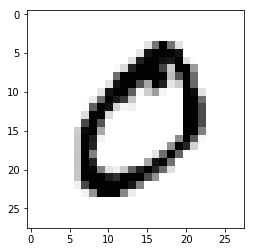

In [8]:
example_image = x_train[1]
example_image_reshaped = example_image.reshape((28, 28)) 
example_label = y_train[1]

print (example_label)
plt.imshow(example_image_reshaped)

## 建立评分函数，损失函数 和 优化算法

现在我们已经对数据有个直接的认识，现在让我们来看看深度学习算法如何基于这些数据训练模型的吧。

首先,我们需要将数据转换成keras模型可处理的形式


### 这里我们需要将数据类型转换成float32 并且正则化数据到[0,1]范围


In [9]:
batch_size = 128
num_classes = 10
epochs = 12

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_train[0])
#print(y_train[0])
 

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.07
  0.07 0.07 0.49 0.53 0.69 0.1  0.65 1.   0.97 0.5  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.12 0.14 0.37 0.6  0.67 0.9

### 然后我们将数据转换为四维数据

In [10]:
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

print('x_train shape:', x_train.shape)
 
print(y_train[0])

x_train shape: (60000, 28, 28, 1)
5


### 我们也需要将label 转换成 one-hot形式，先来看看原来label 是什么样子的

In [11]:
print(y_train[0])

5


### 我们使用keras 中的to_categorical 方法可以方便的将label 转换成one-hot形式

In [12]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 下面是我们模型的整个流程：

`Input -> CONV->CONV (-> ReLU -> Pool) -> DROPOUT -> FLATTEN -> FC -> DROPOUT->FC -> Loss`

### sequential 可以让我们很方便的让我们一层层的搭建网络模型

In [13]:
model = Sequential()

### add函数的作用是向模型中添加网络层
### 32代表在这一层中有多少个filter。

In [14]:
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))

### input_shape 指的是输入数据的格式(28,28,1) ，1表示图片是灰度的，不是彩色,(3,3)表示filter的大小 是一个三行三列的矩阵，激活函数用的是relu

### 我们可以轻松的定义多个网络层

In [15]:
model.add(Conv2D(64, (3, 3), activation='relu'))

### MaxPooling2D 通过一个2\*2的pooling filter 在前一层特征上做点乘，然后取四个值中最大值，这种方式可以减少模型参数

### Dropout 的作用主要是 减少网络连接 从而减少网络参数
### flatten 的作用是将多维经过卷积后的结果平铺成一维向量
### dense 的作用就是fully connected 全连接层

In [16]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

### 我们定义损失函数 去度量 模型在有标签的图片数据集上的性能好坏，这里我们使用[cross entropy loss](https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/).
### 这里使用Adam 进行参数优化

In [17]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### 一些准备就绪，可以让模型在训练集上训练，在测试集上进行验证了
### verbose：日志显示
### verbose = 0 为不在标准输出流输出日志信息
### verbose = 1 为输出进度条记录
### verbose = 2 为每个epoch输出一行记录

In [18]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 242s 4ms/step - loss: 0.2600 - acc: 0.9208 - val_loss: 0.0527 - val_acc: 0.9826
Epoch 2/12
60000/60000 [==============================] - 236s 4ms/step - loss: 0.0852 - acc: 0.9746 - val_loss: 0.0390 - val_acc: 0.9876
Epoch 3/12
60000/60000 [==============================] - 258s 4ms/step - loss: 0.0636 - acc: 0.9816 - val_loss: 0.0398 - val_acc: 0.9861
Epoch 4/12
60000/60000 [==============================] - 263s 4ms/step - loss: 0.0516 - acc: 0.9845 - val_loss: 0.0335 - val_acc: 0.9889
Epoch 5/12
60000/60000 [==============================] - 261s 4ms/step - loss: 0.0451 - acc: 0.9863 - val_loss: 0.0292 - val_acc: 0.9900
Epoch 6/12
60000/60000 [==============================] - 262s 4ms/step - loss: 0.0405 - acc: 0.9873 - val_loss: 0.0280 - val_acc: 0.9905
Epoch 7/12
60000/60000 [==============================] - 254s 4ms/step - loss: 0.0362 - acc: 0.9889 - val_loss: 0.0286 - 

## 保存模型

In [20]:
 model.save('mnist\mnist.h5')

## 对单张图片进行预测
上面我们看到的是对整个测试集进行预测，得到的只是一个最终结果，下面我们将看看如何对一张图片进行预测。

预测结果: 0
实际结果如下图所示：


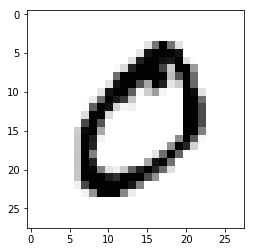

In [21]:
model = load_model('mnist\mnist.h5')
data = example_image.reshape(1,28,28,1)
predicted = model.predict_classes(data, batch_size=1, verbose=0)
print("预测结果:",predicted[0])

print("实际结果如下图所示：")
example_image = x_train[1]
example_image_reshaped = example_image.reshape((28, 28)) 
example_label = y_train[1]
plt.imshow(example_image_reshaped)
